# DATA EXPLORATION


In [2]:
import pandas as pd

# Load the dataset
data = pd.read_csv('cs448b_ipasn.csv')

# Improve display settings
pd.set_option('display.max_columns', None)  # No limit on the number of columns to display
pd.set_option('display.max_rows', 10)       # Display up to 10 rows
pd.options.display.float_format = '{:,.2f}'.format  # Format floats to 2 decimal places

# Display the data
print("First few rows of the dataset:")
display(data.head())
print("\nSummary statistics:")
display(data.describe())


First few rows of the dataset:


,date,l_ipn,r_asn,f
0,2006-07-01,0,701,1
1,2006-07-01,0,714,1
2,2006-07-01,0,1239,1
3,2006-07-01,0,1680,1
4,2006-07-01,0,2514,1



Summary statistics:


,l_ipn,r_asn,f
count,"20,803.00","20,803.00","20,803.00"
mean,4.23,"12,138.32",93.91
std,3.28,"9,766.32","5,765.00"
min,0.00,3.00,1.00
25%,1.00,"4,323.00",1.00
50%,4.00,"8,764.00",2.00
75%,7.00,"17,676.00",8.00
max,9.00,"40,092.00","784,234.00"


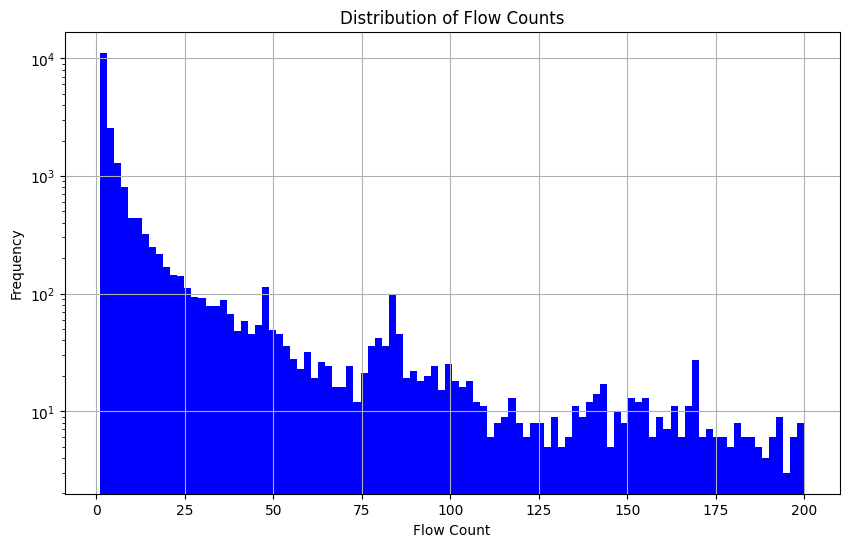

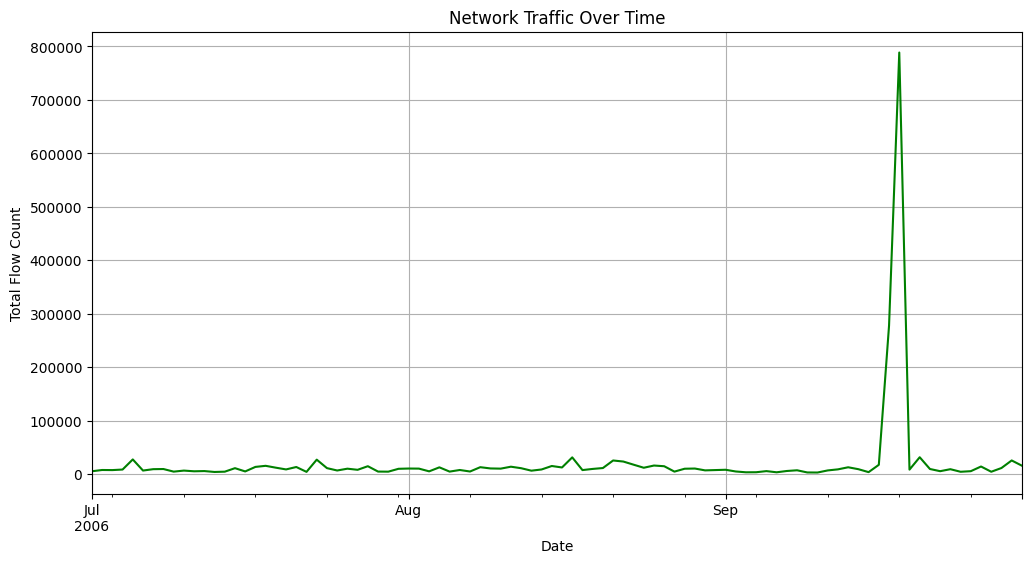

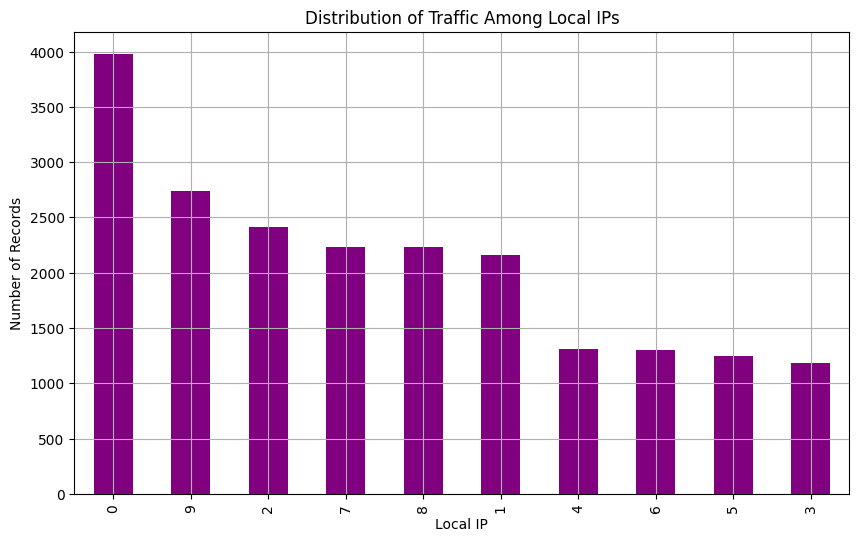

In [3]:
import matplotlib.pyplot as plt

# Convert date to datetime format for better handling
data['date'] = pd.to_datetime(data['date'])

# Visualization 1: Distribution of Flow Counts
plt.figure(figsize=(10, 6))
plt.hist(data['f'], bins=100, color='blue', range=(1,200))  # Limiting range to better visualize the common cases
plt.title('Distribution of Flow Counts')
plt.xlabel('Flow Count')
plt.ylabel('Frequency')
plt.yscale('log')  # Log scale for better visibility of the distribution
plt.grid(True)
plt.show()

# Visualization 2: Network Traffic Over Time
plt.figure(figsize=(12, 6))
data.groupby('date')['f'].sum().plot(kind='line', color='green')
plt.title('Network Traffic Over Time')
plt.xlabel('Date')
plt.ylabel('Total Flow Count')
plt.grid(True)
plt.show()

# Visualization 3: Distribution of Traffic Among Local IPs
plt.figure(figsize=(10, 6))
data['l_ipn'].value_counts().plot(kind='bar', color='purple')
plt.title('Distribution of Traffic Among Local IPs')
plt.xlabel('Local IP')
plt.ylabel('Number of Records')
plt.grid(True)
plt.show()




# Method 1: Simulation

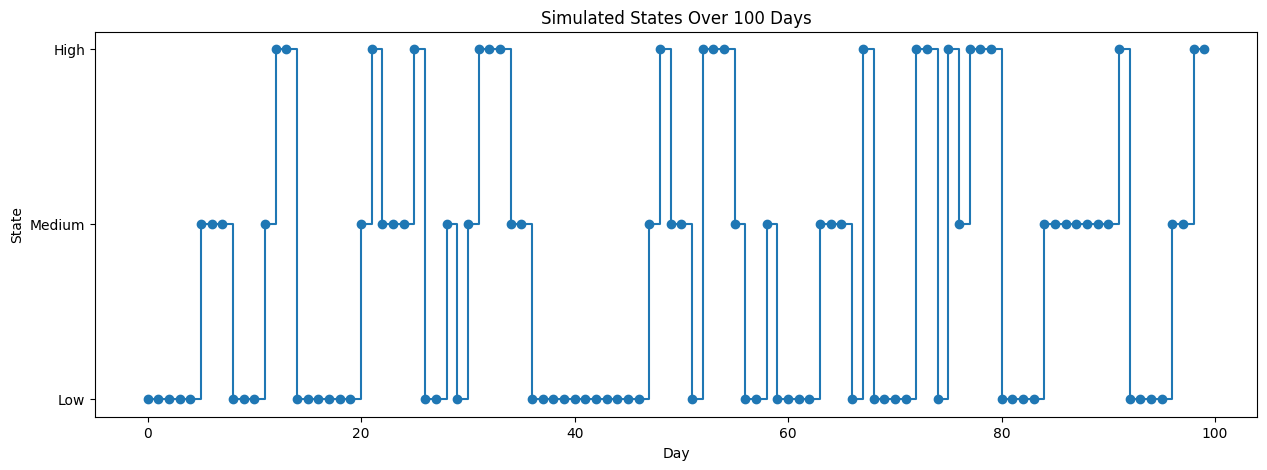

In [4]:
import numpy as np

# Transition matrix
P = np.array([
    [0.7, 0.2, 0.1],  # Low to L, M, H
    [0.3, 0.4, 0.3],  # Medium to L, M, H
    [0.2, 0.3, 0.5]   # High to L, M, H
])

# Function to simulate the Markov chain
def simulate_markov_chain(transition_matrix, initial_state, num_steps):
    # State encoding
    state_dict = {0: 'Low', 1: 'Medium', 2: 'High'}
    inverse_state_dict = {'Low': 0, 'Medium': 1, 'High': 2}
    
    current_state = inverse_state_dict[initial_state]
    states_over_time = [state_dict[current_state]]
    
    for _ in range(num_steps - 1):
        current_state = np.random.choice([0, 1, 2], p=transition_matrix[current_state])
        states_over_time.append(state_dict[current_state])
    
    return states_over_time

# Simulate the system for 100 days
num_days = 100
initial_state = 'Low'
simulated_states = simulate_markov_chain(P, initial_state, num_days)

# Convert state names to numerical values for plotting
state_to_num = {'Low': 0, 'Medium': 1, 'High': 2}
numeric_states = [state_to_num[state] for state in simulated_states]

# Plot the simulated states over the 100 days
plt.figure(figsize=(15, 5))
plt.plot(numeric_states, drawstyle='steps-post', marker='o')
plt.yticks([0, 1, 2], ['Low', 'Medium', 'High'])
plt.title('Simulated States Over 100 Days')
plt.xlabel('Day')
plt.ylabel('State')
plt.show()




# Monte Carlo Simulation

In [5]:
# Function to perform Monte Carlo simulation
def monte_carlo_simulation(transition_matrix, initial_state, num_steps, num_simulations):
    final_states = []

    for _ in range(num_simulations):
        simulated_states = simulate_markov_chain(transition_matrix, initial_state, num_steps)
        final_states.append(simulated_states[-1])  # Record the final state of each simulation

    # Count the occurrences of each state in the final states
    state_counts = {state: final_states.count(state) for state in ['Low', 'Medium', 'High']}
    # Calculate the estimated stationary distribution
    estimated_stationary_distribution = {state: count / num_simulations for state, count in state_counts.items()}

    return estimated_stationary_distribution

# Number of simulations
num_simulations = 10000
# Estimate the stationary distribution
stationary_distribution_estimate = monte_carlo_simulation(P, initial_state, num_days, num_simulations)

stationary_distribution_estimate


{'Low': 0.4525, 'Medium': 0.2866, 'High': 0.2609}

# Estimation

In [6]:
def estimate_transition_matrix_optimized(data, state_column='f'):
    # Determine the number of states
    num_states = data[state_column].nunique()
    
    # Calculate the number of transitions from each state to every other state
    transition_counts = np.zeros((num_states, num_states))
    for i in range(len(data) - 1):
        current_state = int(data.iloc[i][state_column])
        next_state = int(data.iloc[i + 1][state_column])
        transition_counts[current_state, next_state] += 1
    
    # Normalize the rows to get transition probabilities
    transition_matrix = transition_counts / transition_counts.sum(axis=1)[:, np.newaxis]
    
    return transition_matrix

# Calculate the 1st and 3rd quartiles to categorize the 'f' column values into 'Low', 'Medium', 'High'
q1 = data['f'].quantile(0.25)
q3 = data['f'].quantile(0.75)

# Define a function to categorize the values
def categorize_state(value, q1, q3):
    if value <= q1:
        return 0  # 'Low'
    elif q1 < value <= q3:
        return 1  # 'Medium'
    else:
        return 2  # 'High'

# Apply the categorization
data['categorized_f'] = data['f'].apply(lambda x: categorize_state(x, q1, q3))

# Recalculate the transition matrix using the categorized state
estimated_P_categorized = estimate_transition_matrix_optimized(data, 'categorized_f')

estimated_P_categorized


array([[0.46096914, 0.36126239, 0.17776847],
       [0.30142378, 0.4616275 , 0.23694872],
       [0.25089964, 0.41283487, 0.33626549]])

In [7]:
import numpy as np

# Function to compute the log-likelihood of the observed transitions in the data
def log_likelihood(transition_matrix, data, state_column='categorized_f'):
    log_likelihood = 0
    # Iterate over all transitions
    for i in range(len(data) - 1):
        current_state = int(data.iloc[i][state_column])
        next_state = int(data.iloc[i + 1][state_column])
        # Add the log of the transition probability from current_state to next_state
        transition_prob = transition_matrix[current_state, next_state]
        if transition_prob > 0:  # To avoid log(0) which is undefined
            print(f"Transition probability from state {current_state} to state {next_state}: {transition_prob}")
            log_likelihood += np.log(transition_prob)
        else:
            log_likelihood -= np.inf 
            print(f"Transition probability from state {current_state} to state {next_state} is 0.")
    return log_likelihood

# Calculate the log-likelihood for the estimated transition matrix
log_likelihood_value = log_likelihood(estimated_P_categorized, data)
log_likelihood_value


Transition probability from state 0 to state 0: 0.46096913838849324
Transition probability from state 0 to state 0: 0.46096913838849324
Transition probability from state 0 to state 0: 0.46096913838849324
Transition probability from state 0 to state 0: 0.46096913838849324
Transition probability from state 0 to state 0: 0.46096913838849324
Transition probability from state 0 to state 2: 0.17776846809104874
Transition probability from state 2 to state 1: 0.41283486605357855
Transition probability from state 1 to state 1: 0.4616275031832388
Transition probability from state 1 to state 0: 0.3014237758999884
Transition probability from state 0 to state 0: 0.46096913838849324
Transition probability from state 0 to state 0: 0.46096913838849324
Transition probability from state 0 to state 0: 0.46096913838849324
Transition probability from state 0 to state 0: 0.46096913838849324
Transition probability from state 0 to state 0: 0.46096913838849324
Transition probability from state 0 to state 0: 0.

-21937.523442193942

In [8]:

# Convert 'date' to datetime format to extract day of the week
data['date'] = pd.to_datetime(data['date'])
data['day_of_week'] = data['date'].dt.day_name()


# Calculate the frequency of each traffic state for each day of the week
state_frequency_by_day = data.groupby('day_of_week')['categorized_f'].value_counts(normalize=True).unstack().fillna(0)

# Convert the frequency to a more readable percentage format
state_frequency_by_day = state_frequency_by_day * 100

state_frequency_by_day


categorized_f,0,1,2
day_of_week,,,
Friday,33.17,42.06,24.77
Monday,33.86,41.59,24.55
Saturday,34.86,42.50,22.64
Sunday,39.88,39.96,20.16
Thursday,33.47,42.77,23.76
Tuesday,34.85,39.98,25.16
Wednesday,32.44,41.57,25.98


In [9]:
from scipy.stats import chi2_contingency

# Prepare the data for chi-squared test
# The expected format is a frequency table where rows are the days and columns are the traffic states
observed_frequencies = data.groupby('day_of_week')['categorized_f'].value_counts().unstack().fillna(0)

# Perform the chi-squared test
chi2, p_value, dof, expected_frequencies = chi2_contingency(observed_frequencies)

chi2, p_value, expected_frequencies


(55.716097049772685,
 1.3462522445824196e-07,
 array([[ 995.16661059, 1200.70374465,  695.12964476],
        [1076.74893044, 1299.13570158,  752.11536798],
        [ 991.38008941, 1196.13517281,  692.48473778],
        [ 776.92529924,  937.38787675,  542.68682402],
        [1073.65086766, 1295.39777917,  749.95135317],
        [1101.18920348, 1328.62375619,  769.18704033],
        [1145.93899918, 1382.61596885,  800.44503197]]))

In [10]:
from prettytable import PrettyTable

# Assuming 'state_frequency_by_day' is a pandas DataFrame with the traffic state frequencies
# Here we map the state frequencies to their corresponding string labels
state_labels = {0: 'Low', 1: 'Medium', 2: 'High'}
state_frequency_by_day = state_frequency_by_day.rename(columns=state_labels)

# Convert the DataFrame to a PrettyTable with formatted numbers
def dataframe_to_prettytable(df):
    table = PrettyTable()
    
    # Add the headers
    table.field_names = ["Day"] + list(df.columns)
    
    # Add rows to the pretty table from the DataFrame
    for index, row in df.iterrows():
        # Format the float values to two decimal places
        formatted_row = ['{:.2f}'.format(val) if isinstance(val, float) else val for val in row]
        table.add_row([index] + formatted_row)
    
    return table

# Use the function to convert the DataFrame to a pretty table
pretty_table = dataframe_to_prettytable(state_frequency_by_day)
print(pretty_table)


+-----------+-------+--------+-------+
|    Day    |  Low  | Medium |  High |
+-----------+-------+--------+-------+
|   Friday  | 33.17 | 42.06  | 24.77 |
|   Monday  | 33.86 | 41.59  | 24.55 |
|  Saturday | 34.86 | 42.50  | 22.64 |
|   Sunday  | 39.88 | 39.96  | 20.16 |
|  Thursday | 33.47 | 42.77  | 23.76 |
|  Tuesday  | 34.85 | 39.98  | 25.16 |
| Wednesday | 32.44 | 41.57  | 25.98 |
+-----------+-------+--------+-------+


In [11]:
# Define the log-likelihood function
def log_likelihood(transition_matrix, data):
    log_likelihood = 0
    for i in range(len(data) - 1):
        current_state = int(data.iloc[i]['categorized_f'])
        next_state = int(data.iloc[i + 1]['categorized_f'])
        prob = transition_matrix[current_state, next_state]
        if prob > 0:
            log_likelihood += np.log(prob)
        else:
            log_likelihood -= np.inf
    return log_likelihood

# Prepare to collect results
results = []

# Create and analyze transition matrices for each day of the week
days = data['day_of_week'].unique()
transition_matrices = {}

for day in days:
    day_data = data[data['day_of_week'] == day]
    num_states = day_data['categorized_f'].nunique()
    transition_counts = np.zeros((num_states, num_states))
    
    for i in range(len(day_data) - 1):
        current_state = int(day_data.iloc[i]['categorized_f'])
        next_state = int(day_data.iloc[i + 1]['categorized_f'])
        transition_counts[current_state, next_state] += 1

    transition_matrix = transition_counts / transition_counts.sum(axis=1)[:, np.newaxis]
    transition_matrices[day] = transition_matrix
    
    # Calculate log-likelihoods for each model
    ll_model_2 = log_likelihood(transition_matrix, day_data)
    ll_model_1 = log_likelihood(estimated_P_categorized, day_data)
    
    # Store results
    results.append([day, ll_model_2, ll_model_1])

# Convert results to a DataFrame for display
results_df = pd.DataFrame(results, columns=['Day', 'Log-Likelihood Model 2', 'Log-Likelihood Model 1'])

# Print the results table
print(results_df.to_string(index=False))

      Day  Log-Likelihood Model 2  Log-Likelihood Model 1
 Saturday               -3,036.27               -3,039.98
   Sunday               -2,359.74               -2,379.04
   Monday               -3,289.12               -3,291.00
  Tuesday               -3,388.16               -3,390.14
Wednesday               -3,505.56               -3,513.19
 Thursday               -3,270.43               -3,275.38
   Friday               -3,040.55               -3,042.70


In [12]:
import gradio as gr

def predict_risk(day):
    # Use the 'High' state probability from the transition matrix for the specified day
    # Index [2, 2] assumes that the last state and the last column correspond to the 'High' state
    high_risk_prob = transition_matrices[day][2, 2]
    # A risk threshold to define what probability constitutes high risk, e.g., above 0.5
    risk_threshold = 0.35
    risk_message = "High Risk of Compromise" if high_risk_prob >= risk_threshold else "Low Risk of Compromise"
    return f"Probability of High Traffic: {high_risk_prob:.2f}, {risk_message}"

# Corrected Dropdown usage
iface = gr.Interface(
    fn=predict_risk,
    inputs=gr.components.Dropdown(choices=list(transition_matrices.keys()), label="Select Day of the Week"),
    outputs="text",
    title="Network Traffic Compromise Risk Predictor",
    description="Predicts if there is a high risk of compromise based on the network traffic state for a given day."
)

if __name__ == "__main__":
    iface.launch()


C:\Users\smart msi\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
